In [1]:
import pandas as pd
from sqlalchemy import create_engine

# MySQL credentials
user = 'root'
password = 'pass123'
host = 'localhost'
database = 'ecommerce_db'  # Replace with your database name

# SQLAlchemy connection engine
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}/{database}')

# Mapping of CSV file names to target table names
csv_tables = {
    "customers.csv": "customers",
    "geolocation.csv": "geolocation",
    "order_items.csv": "order_items",
    "orders.csv": "orders",
    "payments.csv": "payments",
    "products.csv": "products",
    "sellers.csv": "sellers"
}

# Loop through each CSV and upload to MySQL
for csv_file, table_name in csv_tables.items():
    df = pd.read_csv(csv_file)
    df.to_sql(name=table_name, con=engine, if_exists='replace', index=False)
    print(f"✅ Imported {csv_file} into table `{table_name}`")


✅ Imported customers.csv into table `customers`
✅ Imported geolocation.csv into table `geolocation`
✅ Imported order_items.csv into table `order_items`
✅ Imported orders.csv into table `orders`
✅ Imported payments.csv into table `payments`
✅ Imported products.csv into table `products`
✅ Imported sellers.csv into table `sellers`


# List all unique cities where customers are located

In [2]:
import pymysql
import numpy as np
import pandas as pd
conn=pymysql.connect(host='localhost',user='root',password='pass123',database='ecommerce_db')
cur=conn.cursor()
query="select distinct(customer_city) from customers"
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [19]:
query="select count(order_id) from orders where year(order_purchase_timestamp)=2017";
cur.execute(query)
data=cur.fetchall()
data
"Total orders placed in year 2017:",data[0][0]

('Total orders placed in year 2017:', 45101)

# Find the total sales per category.

In [35]:
query="""SELECT 
    `product category` AS category, 
    SUM(payment_value) AS sales
FROM 
    ecommerce_db.products
JOIN 
    ecommerce_db.order_items 
    ON products.product_id = order_items.product_id
JOIN 
    ecommerce_db.payments 
    ON payments.order_id = order_items.order_id
GROUP BY 
    `product category`;

"""
cur.execute(query)

data = cur.fetchall()
df=pd.DataFrame(data,columns=["category","total_sales"])
df

,category,total_sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


# Calculate the percentage of orders that were paid in installments.

In [47]:
query="""select count(*)/(select count(*) total from payments)*100 as install from payments where payment_installments>=1;
"""
cur.execute(query)
data = cur.fetchall()
data
"the percentage of orders that were paid in installments:",data[0][0]

('the percentage of orders that were paid in installments:',
 Decimal('99.9981'))

# Count the number of customers from each state

<function matplotlib.pyplot.show(close=None, block=None)>

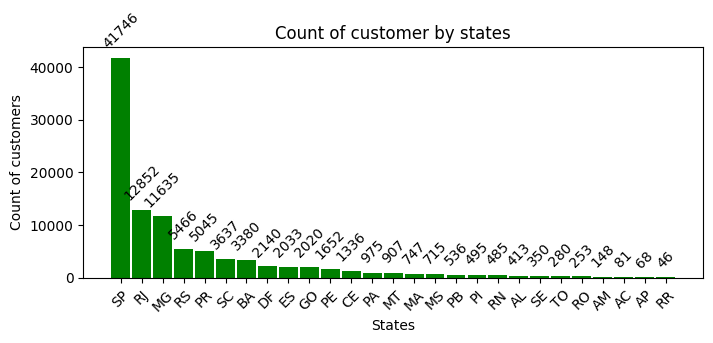

In [31]:
import matplotlib.pyplot as plt
query="select customer_state, count(customer_id) from ecommerce_db.customers group by customer_state;"
cur.execute(query)
data = cur.fetchall()
df=pd.DataFrame(data,columns=["states","total_customers"])
df=df.sort_values(by="total_customers",ascending=False)
df.head()
plt.figure(figsize=(8,3))
bar=plt.bar(df["states"],df["total_customers"],width=0.9,color="g")
plt.title("Count of customer by states")
plt.xlabel("States")
plt.ylabel("Count of customers")
plt.xticks(rotation=45)
plt.bar_label(bar,padding=5,rotation=45)
plt.show



# Calculate the number of orders per month in 2018.

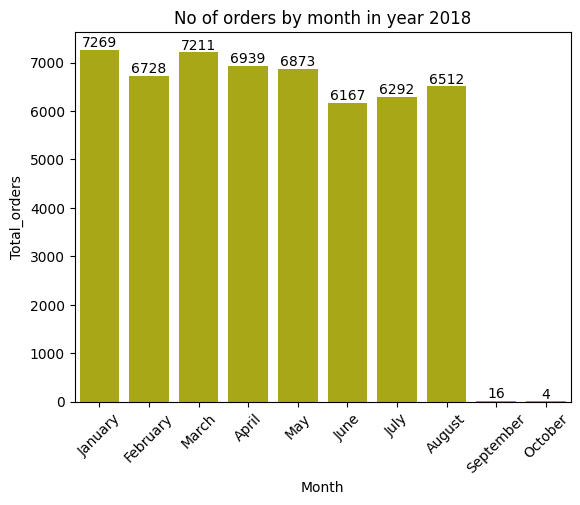

In [55]:
import seaborn as sns
query="""select monthname(order_purchase_timestamp),count(order_id) from orders 
where year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp);"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Month","Total_orders"])
plt.xticks(rotation=45)
o=["January","February","March","April","May","June","July","August","September","October"]
bar=sns.barplot(x=df["Month"],y=df["Total_orders"],order=o,color="y")
bar.bar_label(bar.containers[0])
plt.title("No of orders by month in year 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [64]:
query="""SELECT
    c.customer_city,
    round(AVG(oi.order_item_id),2) AS avg_products_per_order
FROM
    ecommerce_db.customers c
JOIN
    ecommerce_db.orders o ON c.customer_id = o.customer_id
JOIN
    ecommerce_db.order_items oi ON o.order_id = oi.order_id
GROUP BY
    c.customer_city
ORDER BY
    avg_products_per_order DESC;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Customers_city","avg_products_per_order"])
df.head(10)

,Customers_city,avg_products_per_order
0,celso ramos,6.08
1,ipua,4.46
2,padre carvalho,4.00
3,alto paraiso de goias,3.89
4,cicero dantas,3.65
5,datas,3.50
6,candido godoi,3.50
7,uniao da vitoria,3.34
8,morro agudo,3.30
9,inconfidentes,3.14


# Calculate the percentage of total revenue contributed by each product category.

In [67]:
query="""select upper(`product category`),round(sum(payment_value)/(select sum(payment_value) from payments)*100,2)
percentage
from payments p
join
order_items oi on
p.order_id=oi.order_id
join
products pd on
pd.product_id=oi.product_id
group by
`product category`
order by percentage desc;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["Product_category","Percentage distribution"])
df.head(10)

,Product_category,Percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [77]:
query="""select p.`product category`, count(oi.product_id),round(avg(oi.price),2)
from products p join order_items oi on p.product_id=oi.product_id
group by p.`product category`;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
arr1=df["order_count"]
arr2=df["price"]
a=np.corrcoef(arr1,arr2)
print("the correlation coefficient is:",a[0][1])

the correlation coefficient is: -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

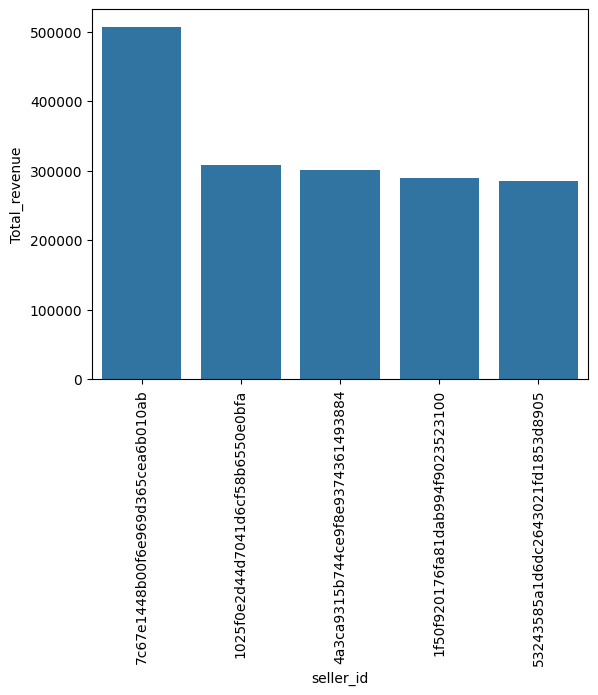

In [17]:
query="""select *, dense_rank() over(order by revenue desc) from 
(select oi.seller_id, sum(p.payment_value) revenue from order_items oi join payments p on oi.order_id=p.order_id
group by oi.seller_id) as a;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["seller_id", "Total_revenue","rank"])
df=df.head()
sns.barplot(x="seller_id",y="Total_revenue",data=df)
plt.xticks(rotation=90)
plt.show()

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Calculate the moving average of order values for each customer over their order history.

In [30]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp) from
(select o.customer_id,o.order_purchase_timestamp,p.payment_value payment
from orders o join payments p on o.order_id=p.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer_id", "order_purchase_timestamp","payment","moving_avg"])
df

,customer_id,order_purchase_timestamp,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,9.49,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate the cumulative sales per month for each year.

In [49]:
query="""select years,months,sales,sum(sales) over(order by years,months) from
(select year(o.order_purchase_timestamp) as years,month(o.order_purchase_timestamp) as months,
sum(p.payment_value) sales from orders o join payments p on o.order_id=p.order_id
group by years,months order by years,months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["years", "months","sales","cum_sales"])
df

,years,months,sales,cum_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [59]:
query="""with a as (select year(o.order_purchase_timestamp) years,round(sum(p.payment_value),2) sales from
orders o join payments p on o.order_id=p.order_id group by years order by years)
select years,sales,lag(sales,1) over(order by years),(sales-lag(sales,1) over(order by years))/lag(sales,1) over(order by years)*100 from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["year", "sales","lag","yoy growth %"])
df

,year,sales,lag,yoy growth %
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [62]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()
data

((None,),)

# Identify the top 3 customers who spent the most money in each year.

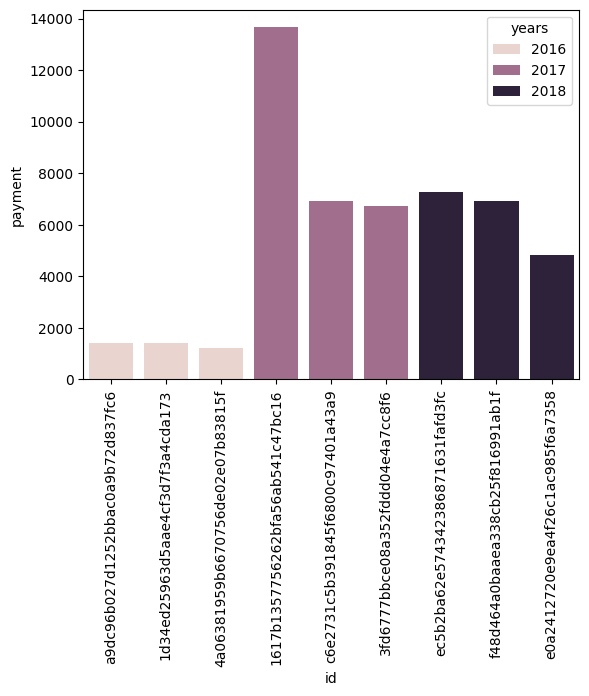

In [87]:
query="""select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()